In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Data from Claire's run

z = np.array([1.151750e+00, 3.648674e+00, 6.564918e+00, 9.970869e+00, 1.394871e+01,
       1.859438e+01, 2.401987e+01, 3.035589e+01, 3.775489e+01, 4.639470e+01,
       5.648257e+01, 6.825986e+01, 8.200741e+01, 9.805146e+01, 1.167703e+02,
       1.386016e+02, 1.640494e+02, 1.936921e+02, 2.281881e+02, 2.682812e+02,
       3.148002e+02, 3.686535e+02, 4.308139e+02, 5.022893e+02, 5.840771e+02,
       6.771003e+02, 7.821267e+02, 8.996818e+02, 1.029968e+03])

mix_depth = 20 # Minimum mixING layer depth
mix_depth_index = (np.abs(z - mix_depth)).argmin()

T_0 = 18 # 'Spun-up' temperature at surface of ocean
T_b = 6 # 'Spun-up' temperature at base of thermocline

def linear_strat(z, T_top, T_base):
    T_mixing = np.array([T_top for i in range(len(z[:mix_depth_index]))])
    T_stratified = (T_top - T_base)/(z[mix_depth_index] - z[-1])*z[mix_depth_index:] + (T_base*z[mix_depth_index] - T_top*z[-1])/(z[mix_depth_index] - z[-1])
    T = np.concatenate([T_mixing, T_stratified])
    return T

temp_0 = linear_strat(z, T_0, T_b) 
print(temp_0)

[18.         18.         18.         18.         18.         18.
 17.93562628 17.86044908 17.77265956 17.67014777 17.55045468 17.41071653
 17.24760114 17.05723766 16.83513766 16.57610816 16.27416871 15.92245655
 15.51315974 15.03745304 14.48550272 13.84653054 13.1089942  12.26093491
 11.29051845 10.1867934   8.94064977  7.54585246  6.        ]


I want: given a temp array -> set the surface to T_0 - 1.5 -> propagate the instability downwards until vanished -> return new temp array and new MLD

In [1]:
# Algorithm for convective adjustment to deepen mixed layer

def cooling(temp, MLD):
    MLD_index = (np.abs(z - MLD)).argmin()
    
    # Initialise convectively unstable array
    
    temp_arr = np.zeros(temp_0.size)
    temp_arr[0:mix_depth_index+1] = T_0 - del_T # Keep setting mixING layer as perturbed surface temp
        
    temp_arr[mix_depth_index+1:] = temp[mix_depth_index+1:]
    
    # Let the mixed layer sink itself; mix successive layers until the convective instability is gone
    
    for i in range(temp_arr.size):
        temp_ave = np.mean(temp_arr[0:i+2])
        if temp_arr[i] <= temp_arr[i+1]: # Convective instability check
            temp_arr[0:i+2] = temp_ave
        else:
            mixed_depth = z[i]
            break
    return temp_arr, mixed_depth

In [7]:
# Step the temp profile forward in time

def step_forward_cooling(temp, MLD_initial, years):
    for i in range(years):
        temp, MLD = cooling(temp, MLD_initial)[0], cooling(temp, MLD_initial)[1]
    return temp, MLD

In [8]:
# 10 years of cooling, spit out temperature profile at the end of 10 year cooling perturbation

cooling_10ann = np.array([step_forward_cooling(temp_0, mix_depth, i)[0] for i in range(1,11)])

In [9]:
step_forward_cooling(temp_0, mix_depth, 10)

(array([15.69928676, 15.69928676, 15.69928676, 15.69928676, 15.69928676,
        15.69928676, 15.69928676, 15.69928676, 15.69928676, 15.69928676,
        15.69928676, 15.69928676, 15.69928676, 15.69928676, 15.69928676,
        15.69928676, 15.69928676, 15.69928676, 15.51315974, 15.03745304,
        14.48550272, 13.84653054, 13.1089942 , 12.26093491, 11.29051845,
        10.1867934 ,  8.94064977,  7.54585246,  6.        ]),
 193.6921)

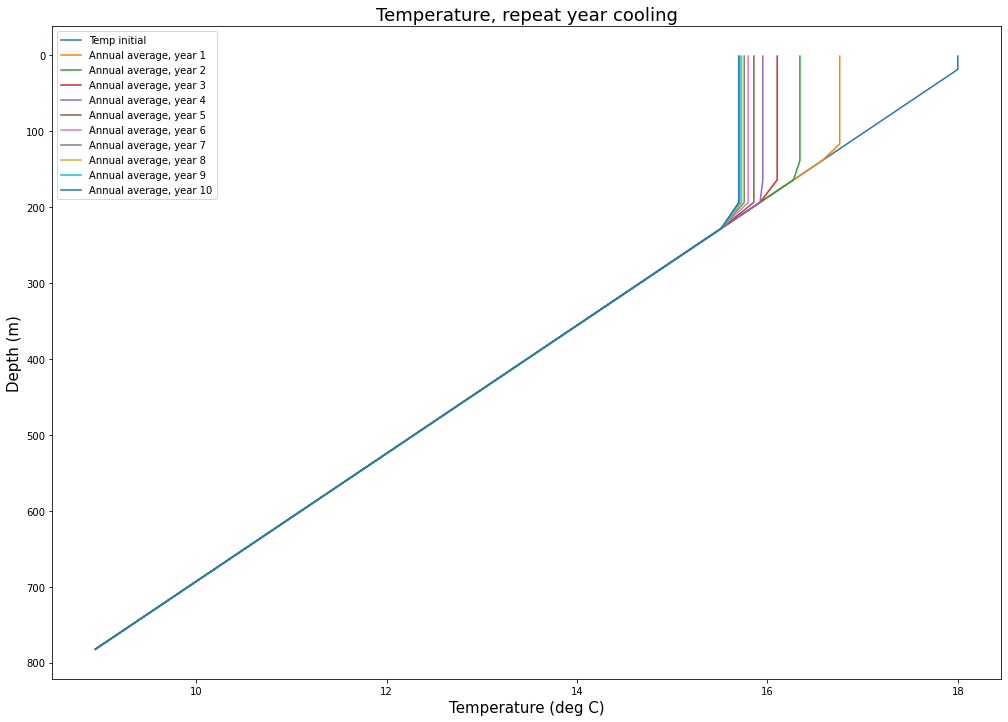

In [10]:
# Plot repeat year cooling

plt.figure(figsize=(17,12))

depth_index = 27
plt.plot(temp_0[:depth_index], z[:depth_index], label='Temp initial')

for i in range(10):
    plt.plot(cooling_10ann[i][:depth_index], z[:depth_index], label='Annual average, year %s' % (i+1))

plt.title('Temperature, repeat year cooling', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.legend()
plt.gca().invert_yaxis()
#plt.savefig('Cooling, 10 years')

In [11]:
def global_ave_temp_anom(temp):
    return np.mean(temp) - np.mean(temp_0)

global_ave_temp_anom_cool1 = np.array([global_ave_temp_anom(step_forward_cooling(temp_0, mix_depth, i)[0]) for i in range(1,10)])

Text(0, 0.5, 'Temperature anomaly (K)')

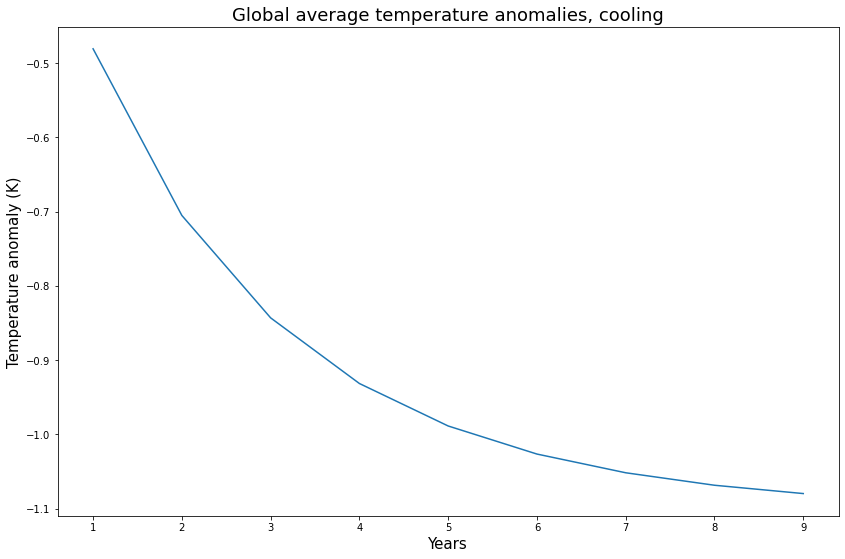

In [12]:
# Plot global average anomalies

time = np.linspace(1,9,9)

plt.figure(figsize=(14,9))
plt.plot(time, global_ave_temp_anom_cool1)
plt.title('Global average temperature anomalies, cooling', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Temperature anomaly (K)', fontsize = 15)
#plt.gca().invert_yaxis()
#plt.savefig('Global average temperature anomaly, cooling, 10 years')

In [13]:
# Algorithm to shoal mixed layer, in the 'cwcw' scheme

def warming(temp):
    # Initialise surface-warmed array
    
    MLD = temp[1] # Pulls the MLD argument from 'step_forward_cooling' 
    MLD_index = (np.abs(z - MLD)).argmin()
    
    T_top = T_0 + del_T + Q/(rho0 * cp * z[MLD_index])*3.15e7
    T_MLD = temp[0][MLD_index]
    
    # Restratify from surface warming
    
    T_mixing_shoaled = np.array([T_top for i in range(len(z[:mix_depth_index]))])
    T_new_strat = (T_top - T_MLD)/(z[mix_depth_index] - z[MLD_index])*z[mix_depth_index:MLD_index] + (T_MLD*z[mix_depth_index] - T_top*z[MLD_index])/(z[mix_depth_index] - z[MLD_index])
    T_old_strat = temp[0][MLD_index:]
    T = np.concatenate([T_mixing_shoaled, T_new_strat, T_old_strat])
    
    return T, z[mix_depth_index+1]

In [14]:
def step_forward_warming(temp, years):
    for i in range(years):
        temp = warming(temp)
    return temp

In [15]:
# 10 years of warming

warming_10ann = np.array([step_forward_warming(step_forward_cooling(temp_0, mix_depth, 10),i)[0] for i in range(1,11)])

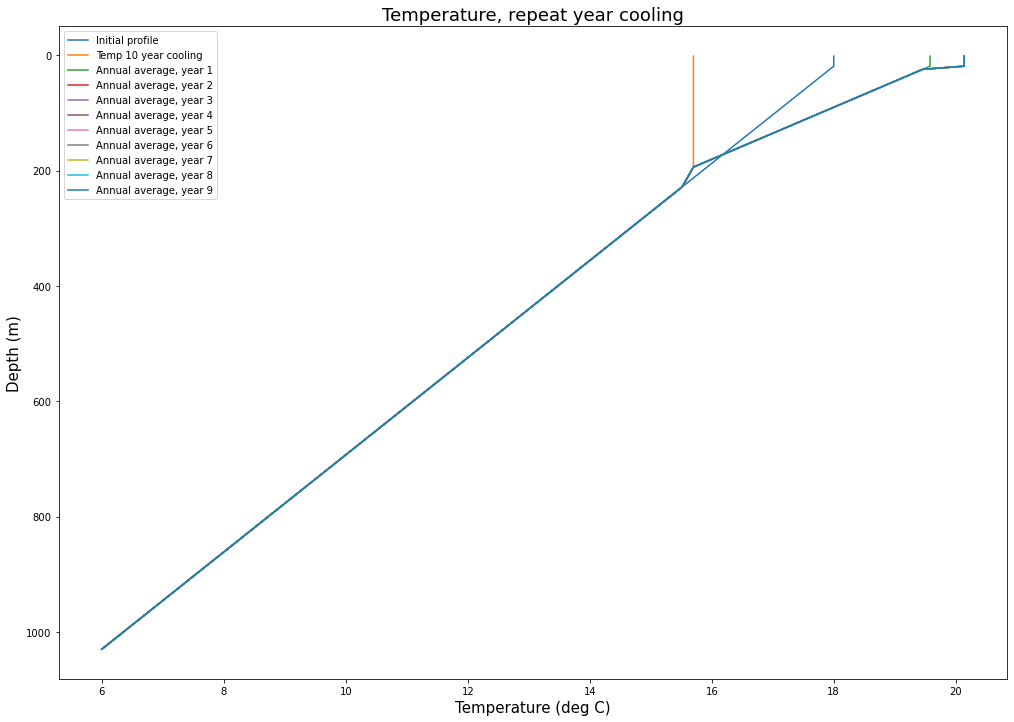

In [16]:
# Plot

plt.figure(figsize=(17,12))

depth_index = 29
plt.plot(temp_0[:depth_index],z[:depth_index],label='Initial profile')
plt.plot(cooling_10ann[-1][:depth_index], z[:depth_index], label='Temp 10 year cooling')

for i in range(9):
    plt.plot(warming_10ann[i][:depth_index], z[:depth_index], label='Annual average, year %s' % (i+1))

plt.title('Temperature, repeat year cooling', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.legend()
plt.gca().invert_yaxis()
#plt.savefig('Warming, 10 years')

In [17]:
# Profile after 10 'years' of cooling

cool10 = step_forward_cooling(temp_0, mix_depth, 10)

In [18]:
# Global average temperature anomalies for 10 years of warming after 10 years of cooling

global_ave_temp_anom_warm1 = np.array([global_ave_temp_anom(step_forward_warming(cool10,i)[0]) for i in range(1,10)]) # Anomalies for 10 'years' of warming

Text(0, 0.5, 'Temperature anomaly (K)')

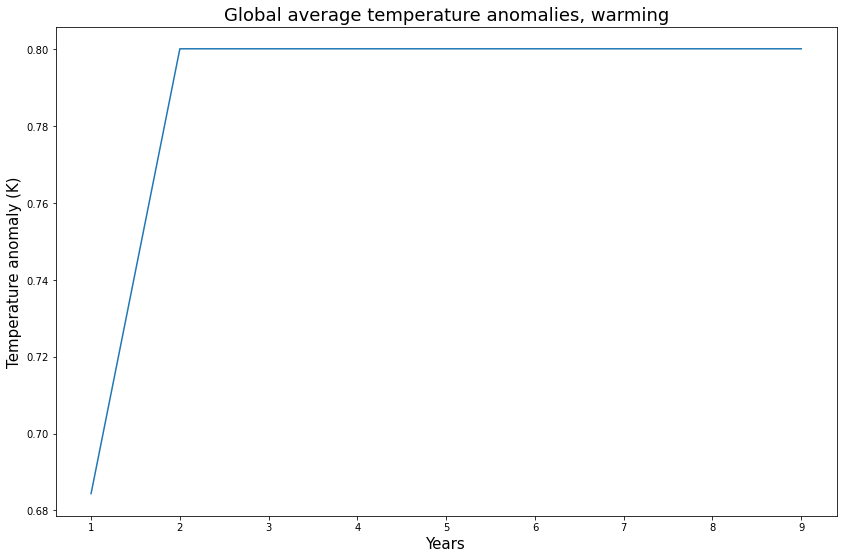

In [19]:
# Plot global average anomalies

plt.figure(figsize=(14,9))
plt.plot(time, global_ave_temp_anom_warm1)
plt.title('Global average temperature anomalies, warming', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Temperature anomaly (K)', fontsize = 15)
#plt.savefig('Global ave temp anomaly, warming, 10 years')

In [20]:
def cwcw(temp, forcing_period, cycles):
    cool = step_forward_cooling(temp, mix_depth, forcing_period)
    for i in range(cycles):
        warm = step_forward_warming(cool, forcing_period)
        cool = step_forward_cooling(warm[0], mix_depth, forcing_period)
    return cool

In [23]:
# Global averages for different number of cwcw oscillations

### Does weird things for certain values of forcing_period - try to work out why! ###

forcing_period = 8
cycles = 8

cwcw_cycles = np.array([cwcw(temp_0, forcing_period, i)[0] for i in range(1,cycles)])
cwcw_cycles_global_ave = np.array([np.mean(cwcw_cycles[i,:]) for i in range(len(cwcw_cycles))])
cwcw_cycles_global_ave_anom = cwcw_cycles_global_ave - cwcw_cycles_global_ave[0]

array([ 0.        , -0.01042565, -0.01115147, -0.011202  , -0.01120552,
       -0.01120576, -0.01120578])

Text(0, 0.5, 'Temperature anomaly (K)')

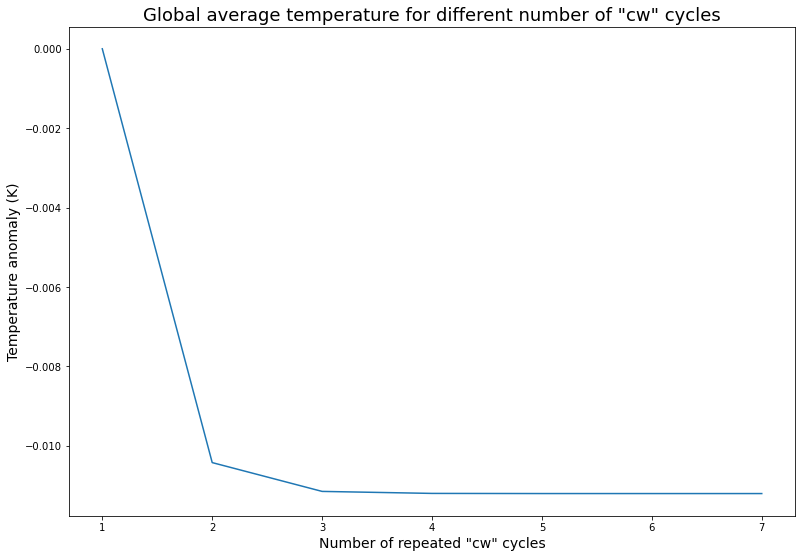

In [22]:
# Plot global averages for different number of cwcw oscillations

plt.figure(figsize=(13,9))
plt.plot(np.linspace(1,len(cwcw_cycles_global_ave_anom),len(cwcw_cycles_global_ave_anom)),cwcw_cycles_global_ave_anom)
plt.title('Global average temperature for different number of "cw" cycles',fontsize=18)
plt.xlabel('Number of repeated "cw" cycles',fontsize=14)
plt.ylabel('Temperature anomaly (K)',fontsize=14)
#plt.savefig('Repeat cw cycles show net cooling')

In [228]:
# Add a flux response to incorporate the fact that a shallowed mixed layer means less heat capacity means more mixed layer temp increase for a given surface heat flux

# Add diffusion for temp below MLD